In [ ]:
!nvidia-smi

Tue Mar  9 15:17:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from IPython.display import clear_output
# !pip install tensorflow
!pip install tf-image
!pip install tensorflow-addons
clear_output()

In [ ]:
import matplotlib.pyplot as plt 
import cv2
from PIL import Image
import tensorflow as tf 
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras import optimizers
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import tensorflow_addons as tfa

from PIL import Image

from tf_image.core.random import random_function
from tf_image.core.colors import rgb_shift, channel_drop
from tf_image.core.convert_type_decorator import convert_type

**All** variable initialization

In [ ]:
split_ratio = 0.005
threshold = 0.95
wieght = 0.0001
random_seed = 42

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


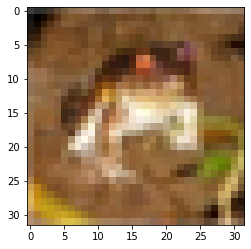

In [ ]:
plt.imshow(x_train[0], cmap="gray")
plt.show() 

In [ ]:
len(x_train)

50000

In [ ]:
len(x_test)

10000

In [ ]:
x_final_pseudolabel,x_final_train,y_final_pseudolabel,y_final_train = train_test_split(x_train, y_train, test_size=split_ratio, random_state= random_seed )

In [ ]:
len(x_final_train)

250

In [ ]:
x_final_train.shape

(250, 32, 32, 3)

In [ ]:
# Normalize the train dataset
x_final_train = tf.keras.utils.normalize(x_final_train, axis=1)

Taking only 250 image sample for our data

In [ ]:
#MODEL
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D(2,2),
     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'), 
     tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(128, activation='relu'), 
     tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(16, activation='relu'), 
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')  
    
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               295040    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0

In [ ]:
model.compile(optimizer='sgd',
    loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history=model.fit(x_final_train,y_final_train,epochs=20,shuffle=False)

Epoch 1/20
8/8 [==============================] - 30s 15ms/step - loss: 2.3116 - accuracy: 0.1291
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 2.3005 - accuracy: 0.1090
Epoch 3/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2985 - accuracy: 0.1277
Epoch 4/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2932 - accuracy: 0.1323
Epoch 5/20
8/8 [==============================] - 0s 6ms/step - loss: 2.3006 - accuracy: 0.1058
Epoch 6/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2890 - accuracy: 0.1144
Epoch 7/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2835 - accuracy: 0.1169
Epoch 8/20
8/8 [==============================] - 0s 6ms/step - loss: 2.3041 - accuracy: 0.1054
Epoch 9/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2893 - accuracy: 0.1807
Epoch 10/20
8/8 [==============================] - 0s 6ms/step - loss: 2.2837 - accuracy: 0.1174
Epoch 11/20
8/8 [====================

In [ ]:
#Weak Augmentation

def weak_augmentation(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.keras.preprocessing.image.random_shift(
    image, 0.2, 0.3,)
  return image



In [ ]:
def randaugment_image(image):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image,0.1,0.3)
  image = tf.image.random_brightness(image,0.5)
  seed = (1, 2)
  image = tf.image.stateless_random_saturation(image, 0.1, 0.3, seed)
#image = tf.image.stateless_random_crop(image,size=(1, 2, 3), seed=seed)
  image = tf.image.stateless_random_hue(image, 0.2, seed)
  image = tfa.image.sharpness(image,2,"sharpness")
  image = tfa.image.shear_x(image,0.1,0.2)
  image = tfa.image.shear_y(image,0.1,0.2)
  image = tfa.image.equalize(image)
  image = tfa.image.rotate(image, 5)
  image = tf.keras.preprocessing.image.random_shift(
    image, 0.1, 0.2,)
  return image

**PseudoLabeling weak Augmented Data**

In [ ]:
counter=0
X= np.empty((1,32,32,3),dtype=int)
Y= np.empty((1),dtype=int)

for i in range (0,x_final_pseudolabel.shape[0]):  
  x=x_final_pseudolabel[i]
  x_aug= weak_augmentation(x)
  x_expand=np.expand_dims(x_aug, axis=0)
  images = np.vstack([x_expand])

  classes = model.predict(images)
 
  if(classes.max()>0.95):
    x_strong_aug = randaugment_image(x_final_pseudolabel[i])
    X=np.append(X,x_strong_aug.reshape(1,32,32,3),axis=0)  #heavily augmented images
    Y=np.append(Y,(np.argmax(classes)))  #Pseudolabel


    counter=counter+1
  print(counter)
X=np.delete(X, 0, 0)
Y=np.delete(Y,0,0)

clear_output()


In [ ]:
print(X.shape)
print(Y.shape)

(49408, 32, 32, 3)
(49408,)


In [ ]:
X = tf.keras.utils.normalize(X, axis=1)

In [ ]:
history=model.fit(X,Y,epochs=50,shuffle=False)

Epoch 1/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.6169 - accuracy: 0.8417
Epoch 2/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5537 - accuracy: 0.8432
Epoch 3/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5351 - accuracy: 0.8433
Epoch 4/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5256 - accuracy: 0.8430
Epoch 5/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5195 - accuracy: 0.8431
Epoch 6/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5117 - accuracy: 0.8431
Epoch 7/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.5050 - accuracy: 0.8432
Epoch 8/50
1544/1544 [==============================] - 10s 6ms/step - loss: 0.4996 - accuracy: 0.8435
Epoch 9/50
1544/1544 [==============================] - 10s 6ms/step - loss: 0.4928 - accuracy: 0.8438
Epoch 10/50
1544/1544 [==============================] - 9s 6ms/step - loss: 0.4